# Simulatie - les 3

Notebook bij les 3 van de leerlijn simulatie van S3 - AI. 

© Auteur: Joost Vanstreels

**Voorbereiding voor les 3:**
- We kijken weer even terug naar de uniforme, normale en lognormale verdeling die zijn besproken in het eerste college over Distributies (zie data_les5.ipynb). Kijk nog even terug naar dat college.

In [156]:
# import benodigde libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson_ksamp, PermutationMethod

## Synthetische data
Tijdens colleges 1 en 2 hebben we gebruikt gemaakt van een bestaande dataset. In de praktijk wordt echter vaak gebruik gemaakt van *synthetische* data. Dat is data die gegenereerd is op basis van kenmerken van historische data. Er zijn meerdere redenen voor het gebruik van synthetische data:
- Synthetische data kan onbeperkt gegenereerd worden, dat is handig wanneer de historische dataset klein is;
- Soms is er geen historische data beschikbaar, maar zijn wel kenmerken van een event beschikbaar (zoals de centrum- en spreidingsmaten) waarmee data gegenereerd kan worden;
- Historische data kan toevalligheden bevatten waarop een model of simulatie kan *overfitten*;
- Met synthetische data kunnen nieuwe situaties nagebootst worden, denk bij de ICU aan minder of juist meer instroom. Tijdens de Covid-pandemie konden ICU's verschillende scenario's met instroom van patiënten genereren.

Tijdens dit college gaan we kijken naar manieren om synthetische data te genereren om complexere experimenten uit te voeren. We gaan er vanuit dat de historische data een bepaalde verdeling volgt. We blikken daarom eerst terug op de verschillende verdelingen die behandeld zijn en introduceren een vierde verdeling: de Poisson-verdeling. Daarna bekijken we drie methodes om te bepalen welke verdeling van toepassing is en wat de parameters waren.

## Data ICU casus
Voordat we de theorie in duiken, is het goed om eerst te realiseren wat we later in dit college gaan doen met het genereren van synthetische data. Voor de ICU casus gebruikte we een historische dataset met daarin per tijdstip een bepaald aantal patiënten dat arriveerde bij de ICU en voor elke patiënt een bepaalde ligtijd in bed. We gaan straks proberen te achterhalen hoe deze aankomstdata en ligdata verdeeld is zodat we synthetische data kunnen genereren die vergelijkbaar is met de historische data.

De historische data is te vinden in de map ```examples\icu\simulatiedata.csv```.

## Verdelingen
Om synthetische data te kunnen genereren, moeten we ten eerste weten welke verdeling de data moet volgen en wat de waarden voor de parameters van de verdeling moeten zijn. We hebben eerder al gekeken naar de uniforme, normale en lognormale verdeling en we introduceren twee nieuwe verdelingen: de Poisson verdeling en de exponentiële verdeling.

### Uniforme, normale en lognormale verdeling
De uniforme, normale en lognormale verdeling zijn besproken in het eerste college over Distributies (zie data_les5.ipynb). Deze verdelingen verschillen erg van elkaar zoals je hieronder kunt zien.

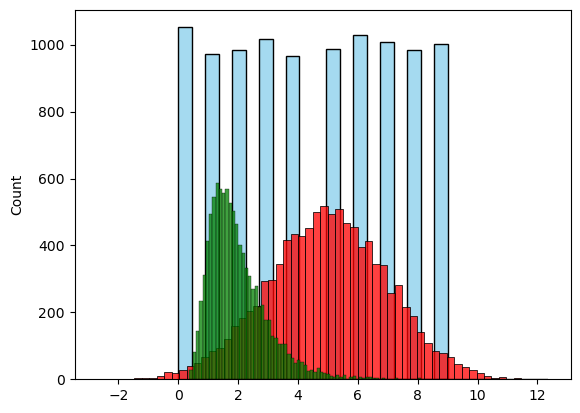

In [157]:
# Uniforme data genereren
# Parameters
bereik = np.arange(0,10) 
aantal = 10000

# Random trekkingen uit verdeling maken
uniforme_data = np.random.choice(bereik, aantal)

# Normaalverdeelde data genereren
# Parameters
mu, sigma = 5, 2
aantal = 10000

# Random trekkingen uit verdeling maken
normale_data = np.random.normal(mu, sigma, aantal)

# Lognormaalverdeelde data genereren
# De parameters voor de lognormal functie zijn de mean en standaarddeviatie van de onderliggende normaalverdelingen, 
# deze berekening is nodig om terug te rekenen van lognormaal naar normaal
mean_data = 2
std_data = 1
mu = np.log((mean_data**2) / np.sqrt(std_data**2 + mean_data**2))
sigma = np.sqrt(np.log(1 + (std_data**2) / (mean_data**2)))
aantal = 10000

# Random trekkingen uit verdeling maken
lognormale_data = np.random.lognormal(mu, sigma, aantal)

# Data plotten
sns.histplot(data=uniforme_data, color="skyblue", label="Uniforme data", kde=False)
sns.histplot(data=normale_data, color="red", label="Normaalverdeelde data", kde=False)
sns.histplot(data=lognormale_data, color="green", label="Lognormaalverdeelde data", kde=False)

plt.show()

### Poissonverdeling
De normale verdeling is een continue verdeling, en die kun je gebruiken om de kans uit te rekenen dat een normaalverdeelde variabele een bepaalde waarde aanneemt. Denk aan het berekenen van de kans dat een pinguin een snavellengte heeft van meer dan 50mm.

De Poisson-verdeling is een discrete verdeling en wordt gebruikt om het aantal gebeurtenissen in een vast tijdsinterval te modelleren, waarbij de gebeurtenissen onafhankelijk van elkaar plaatsvinden. Denk aan:
- Het aantal klanten dat in een uur een winkel binnenkomt.
- Het aantal telefoontjes dat een callcenter ontvangt in een bepaalde periode.
- Het aantal defecte producten in een productielijn per uur.

De Poisson-verdeling wordt gekarakteriseerd door één parameter, $\lambda$ (lambda), die het gemiddelde aantal gebeurtenissen per tijdseenheid aangeeft. De kans op het waarnemen van $k$ gebeurtenissen in een interval wordt gegeven door de formule:
$$ P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!} $$

Een voorbeeld:
Stel er komen gemiddeld 5 klanten per uur de winkel binnen. Wat is dan de kans dat in een gegeven uur precies 3 klanten binnenkomen? We willen berekenen $P(X = 3)$, waarbij $X$ het aantal klanten is dat binnenkomt in een uur. Nu kunnen we de formule invullen:
$P(X = 3) = \frac{5^3 e^{-5}}{3!} = 0.14$

Of we rekenen het uit uitrekenen met python:

In [158]:
#definieer functie voor de poisson verdeling:
def poisson(l, k):
    return l**k * np.exp(-l) / math.factorial(k)

In [159]:
#Bereken P(X=3):
print(f"De kans dat er 3 mensen in een uur binnen komen is {poisson(5, 3):.2f}")

De kans dat er 3 mensen in een uur binnen komen is 0.14


Stel je nu voor dat de kassiere even stieken wilt gaan roken en ze wilt de kans uitrekenen dat er niemand binnenkomt in de tijd dat ze weg is. Hoe groot is de kans dat er in 10 minuten (de tijd die ze nodig heeft), niemand binnen komt?

Om deze vraag te beantwoorden moeten we eerst de parameter $\lambda$ omrekenen. We weten dat er gemiddeld 5 klanten per uur binnenkomen, dus in 10 minuten (1/6 uur) is dat $\frac{5}{6}$. Hiermee rekenen we dan verder:

$P(X = 0) = \frac{(\frac{5}{6})^0 e^{-\frac{5}{6}}}{0!} = e^{-\frac{5}{6}} = 0.43$

Of met onze python funcie:

In [160]:
print(f"De kans dat er geen klanten binnenkomen als de kassiere weg is, is: {poisson(5/6, 0):.2f}")

De kans dat er geen klanten binnenkomen als de kassiere weg is, is: 0.43


### Opdracht 1
Gemiddeld komen er per week 10 patienten met ziekte A naar het ziekenhuis. Bereken het volgende:
1. De kans dat er op 1 dag 2 patienten met ziekte A binnenkomen.
2. De kans dat er op 1 dag meer dan 2 patienten met ziekte A binnenkomen.

**Tip 1:** Bedenk eerst wat de juiste waarde voor $\lambda$ is. 

**Tip 2:** 'meer dan 2' patienten is niet makkelijk uitrekenen, het kan namelijk zijn dat er 3, 4, 5, etc patienten binnenkomen. Bereken hiervoor de kans op 0, 1 en 2 patienten en trek dit af van 1.

In [161]:
#1
print(poisson(10/7, 2))

#2
print(1 - poisson(10/7, 0) - poisson(10/7, 1) - poisson(10/7, 2))

0.2445418739201794
0.1734484661497937


### Kansdichtheidsgrafiek van de Poissonverdeling
Om een beeld te krijgen van hoe de kansdichtheidsgrafiek van een Poisson-verdeling eruit ziet, gaan we 1000 uur simuleren waarin gemiddeld 5 klanten per uur binnenkomen. Hiervoor gebruiken we `np.random.poisson` (zie: https://numpy.org/doc/2.1/reference/random/generated/numpy.random.poisson.html)

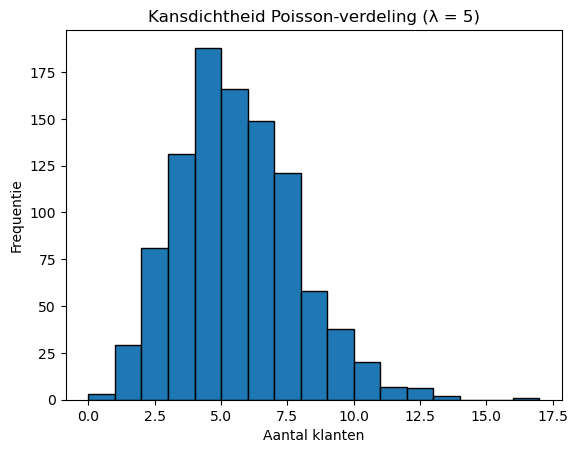

In [162]:
# Stel de parameters in
rate = 5  # gemiddelde aantal klanten per uur
aantal = 1000  # aantal simulaties

# Random trekkingen uit verdeling maken
poisson_data = np.random.poisson(lam=rate, size=aantal)
# Data plotten
plt.hist(poisson_data, bins=(poisson_data.max()-poisson_data.min()), edgecolor='black')
plt.title('Kansdichtheid Poisson-verdeling (λ = 5)')
plt.xlabel('Aantal klanten')
plt.ylabel('Frequentie')
plt.show()

Je ziet in deze grafiek een piek bij 5 klanten, wat logisch is omdat dat het gemiddelde aantal per uur is. Hoe verder we van dit gemiddelde af gaan, hoe kleiner de kans wordt. Uiteraard kunnen er niet minder dan 0 klanten per uur binnen komen, maar gebeurt het wel een enkele keer dat er heel veel (13 of 14) klanten binnen komen.

Hieronder nog een voorbeeld van een Poisson-verdeling met een hele hoge lambda. Merk op hoe dit bij een groot genoege sample erg op een normaalverdeling gaat lijken.

Text(0, 0.5, 'Kansdichtheid')

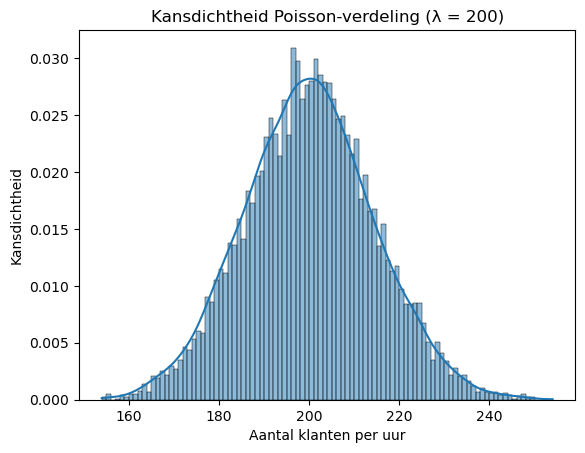

In [163]:
# Data volgens Poisson verdeling genereren

# Parameters
rate = 200
aantal = 10000

#set seed
np.random.seed(0)

# Random trekkingen uit verdeling maken
poisson_data = np.random.poisson(lam=rate, size=aantal)

# Data plotten
sns.histplot(poisson_data, bins=100, stat="probability", kde=True)
plt.title('Kansdichtheid Poisson-verdeling (λ = 200)')
plt.xlabel('Aantal klanten per uur')
plt.ylabel('Kansdichtheid')

### Sampelen uit een verdeling
Je kent nu 4 verschillende verdelingen, de uniforme, normale, lognormale en poisson verdeling. Om zelf data te generen die aan een van deze verdelingen voldoet, kun je gebruik maken de random module van numpy. Belangrijk is telkens dat je de juiste parameters gebruikt.

**Voorbeeld:**
 
Trek 10 samples uit een normale verdeling met gemiddelde 10 en standaarddeviatie 2.

In [164]:
samples_normaal = np.random.normal(loc=10, scale=2, size=10)
print(f"10 samples uit een normale verdeling met mu = 10 en sd = 2: {samples_normaal}")

10 samples uit een normale verdeling met mu = 10 en sd = 2: [ 8.28377217 11.61239363  7.87210548  9.78836449 10.85523374  8.35207933
 13.61796961  6.84027257  9.93955734  9.36120771]


### Opdracht 2
1. Trek 1000 samples uit een uniforme verdeling tussen 0 en 10.
2. Trek 1000 samples uit een lognormale verdeling met $\mu = 4$ en $\sigma = 1.5$ (beide zijn de waardes voor de onderliggende normaalverdeling).
3. Trek 1000 samples uit een Poisson-verdeling met $\lambda = 2$.
4. Maak een visualisatie waarin je de histogrammen van de verschillende verdelingen vergelijkt. 

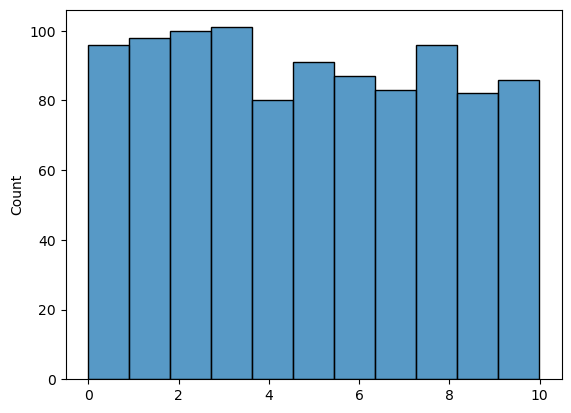

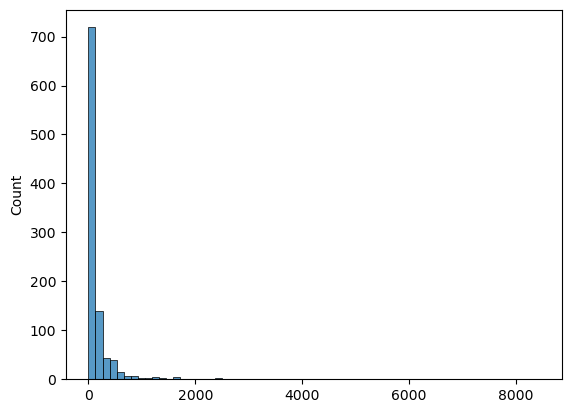

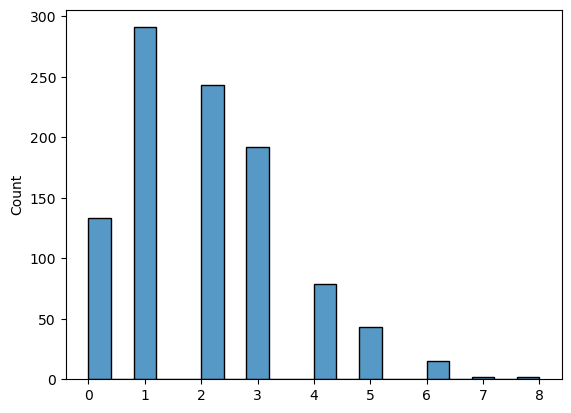

In [165]:
samples_uniform = np.random.uniform(0, 10, 1000)
samples_lognormal = np.random.lognormal(4, 1.5, 1000)
samples_poisson = np.random.poisson(2, 1000)

sns.histplot(samples_uniform)
plt.show()
sns.histplot(samples_lognormal)
plt.show()
sns.histplot(samples_poisson)
plt.show()

## Verdeling bepalen
We weten nu welke verdelingen er zijn en kunnen data genereren volgens zo'n verdeling. Maar we moeten het ook andersom kunnen doen: wanneer we data krijgen moeten we kunnen achterhalen welke verdeling er gevolgd wordt. Daar zijn drie manieren voor.

### Methode 1. Plotten
De meest simpele manier, maar ook de meest foutgevoelige manier, is het plotten van de verdeling van de data en *met het oog* bepalen of de verdelingen hetzelfde zijn. 

In [166]:
# Testdata inladen
df = pd.read_csv('../databronnen/testdata.csv')
testdata = df['Data']

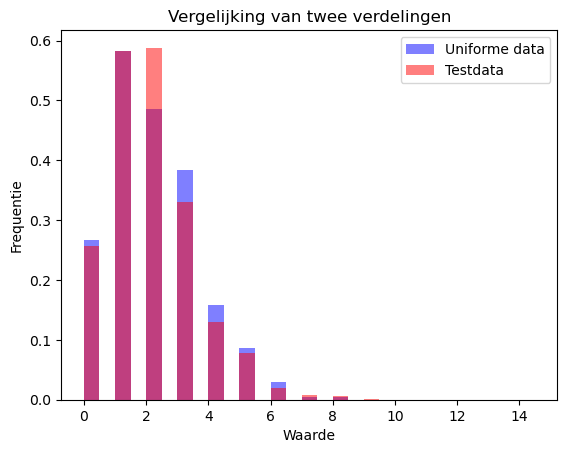

In [167]:
# Vaste bins geven meer overzicht
bins = np.arange(0, 15, 0.5)

# Twee histogrammen plotten
plt.hist(samples_poisson, bins=bins, alpha=0.5, label='Uniforme data', color='blue', density=True)
plt.hist(testdata, bins=bins, alpha=0.5, label='Testdata', color='red', density=True)

# Legenda
plt.legend()

# Titels en labels
plt.title('Vergelijking van twee verdelingen')
plt.xlabel('Waarde')
plt.ylabel('Frequentie')

plt.show()

Deze methode is interessant om te bepalen welke verdelingen sowieso afvallen, maar je kunt nog geen conclusie trekken of een verdeling wel past

### Opdracht 3
Pas bovenstaande visualisatie aan en bepaal welke van de vier gegeven datasets (```uniforme_data```, ```normale_data```, ```lognormale_data``` en ```poisson_data```) het beste overeenkomt met de testdata (```testdata```). 

Poisson past het beste

### Methode 2. QQ plot
Een betere, maar ook nog steeds niet foutloze, manier is het maken van een *Quantile-Quantile* plot. Het idee is dat je de samples uit beide datasets sorteert in oplopende volgorde en daarna een scatterplot genereert. Wanneer de scatterplot een rechte lijn volgt, zijn de verdelingen hetzelfde.

In dit blog wordt de werking erg goed uitgelegd: https://blog.dailydoseofds.com/p/a-visual-and-intuitive-guide-to-qq.

#### Voorbeeld
Stel dat je de volgende twee datasets hebt:
1. ```[0,1,3,4,5,6]```
2. ```[1,2,3,4,4,6]```

De scatterplot bestaat uit de volgende punten: ```(0,1), (1,2), (3,3), (4,4), (5,4), (6,6)```. Wanneer je dit plot en een rechte lijn er doorheen trekt, kun je zien waar de afwijkingen liggen. 


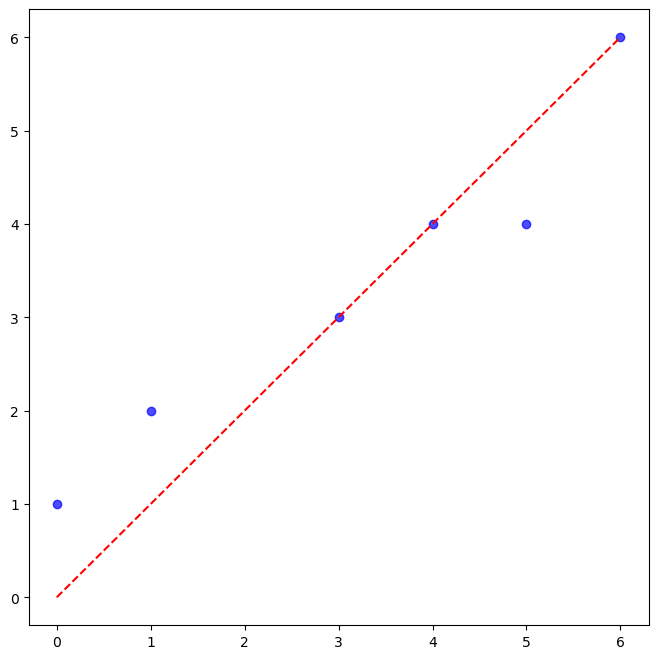

In [168]:
# Datasets
dataset1 = np.array([0,1,3,4,5,6])
dataset2 = np.array([1,2,3,4,4,6])

# Data plotten
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(dataset1, dataset2, alpha=0.7, color='blue')

# Rechte lijn plotten
min_val = min(dataset1.min(), dataset2.min())
max_val = max(dataset1.max(), dataset2.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--')

### Datasets met verschillende grootte
Het voorbeeld hierboven gaat over twee datasets die even groot zijn, maar dat is geen vereiste. De QQ-plot, de naam zegt het al, gebruikt namelijk de data op bepaalde kwantielen om zo ook datasets van verschillende groottes te kunnen vergelijken.

In de code hieronder zie je dat de eerste dataset twee keer zo groot is als de tweede. Er worden daarna 12 kwantielen gemaakt. ```x_quantiles``` is logischerwijs hetzelfde als ```dataset1``` maar ```y_quantiles``` is groter dan ```dataset2```. Het resultaat zijn twee gelijke datasets die vergeleken kunnen worden.

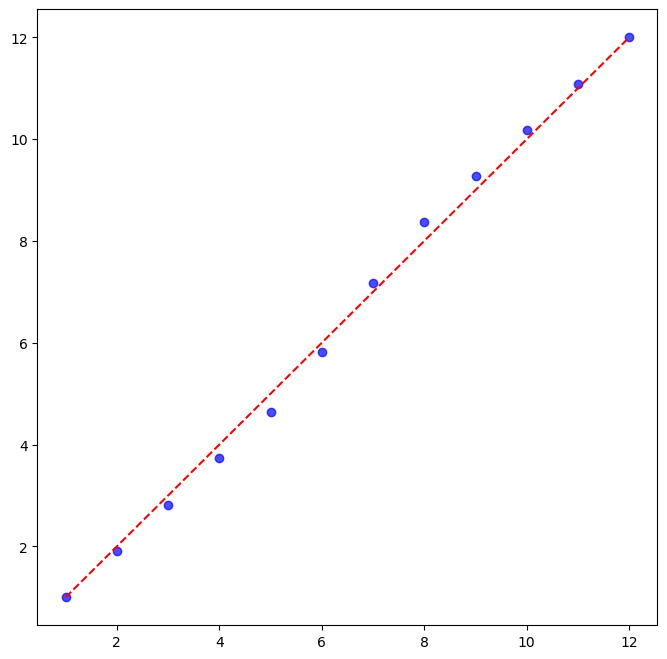

In [169]:
# Datasets
dataset1 = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
dataset2 = np.array([1,3,5,8,10,12])

# Kwantieldata genereren
x_quantiles = np.quantile(dataset1, np.linspace(0, 1, 12))
y_quantiles = np.quantile(dataset2, np.linspace(0, 1, 12))

# Data plotten
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_quantiles, y_quantiles, alpha=0.7, color='blue')

# Rechte lijn plotten
min_val = min(dataset1.min(), dataset2.min())
max_val = max(dataset1.max(), dataset2.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--')

Het voordeel van deze QQ-plot ten opzichte van de verdelingen plotten, is dat je visueel beter kunt bepalen of datasets écht dezelfde verdeling hebben of écht niet, maar bij twijfel geeft de QQ-plot nog steeds geen antwoord. Ook werkt de QQ-plot niet goed bij kleine datasets of weinig diversiteit qua waardes.

### Opdracht 4
Maak voor elk van de vier datasets een QQ-plot met de testdata en bepaal welke van de vier datasets het beste overeenkomt met de testdata.

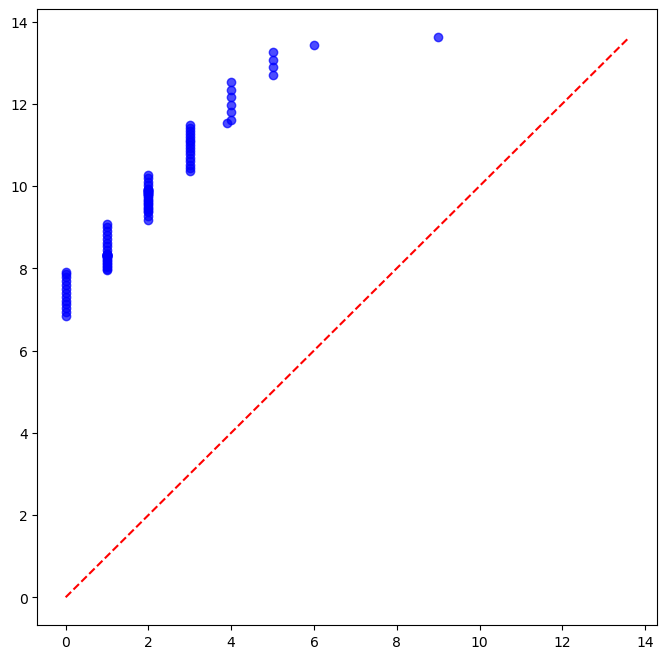

In [170]:
x_quantiles = np.quantile(testdata, np.linspace(0, 1, 100))
y_quantiles = np.quantile(samples_normaal, np.linspace(0, 1, 100))

# Data plotten
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_quantiles, y_quantiles, alpha=0.7, color='blue')

# Rechte lijn plotten
min_val = min(testdata.min(), samples_normaal.min())
max_val = max(testdata.max(), samples_normaal.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--')

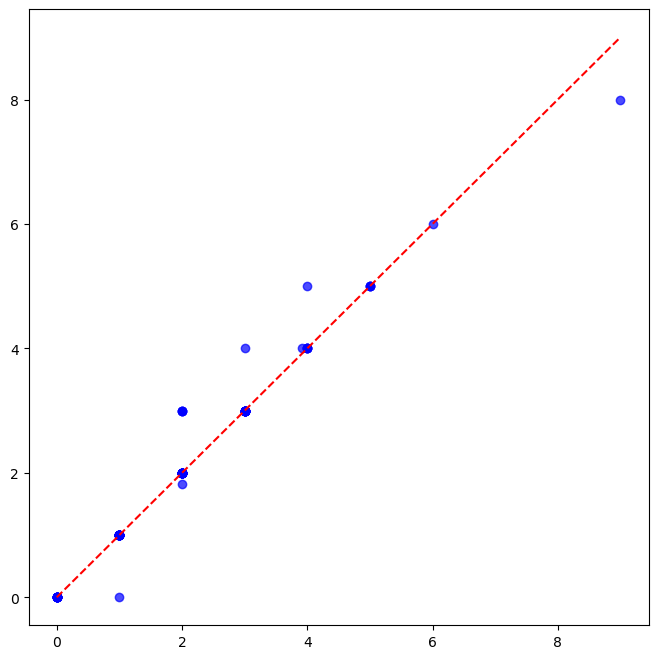

In [171]:
x_quantiles = np.quantile(testdata, np.linspace(0, 1, 100))
y_quantiles = np.quantile(samples_poisson, np.linspace(0, 1, 100))

# Data plotten
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_quantiles, y_quantiles, alpha=0.7, color='blue')

# Rechte lijn plotten
min_val = min(testdata.min(), samples_poisson.min())
max_val = max(testdata.max(), samples_poisson.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--')

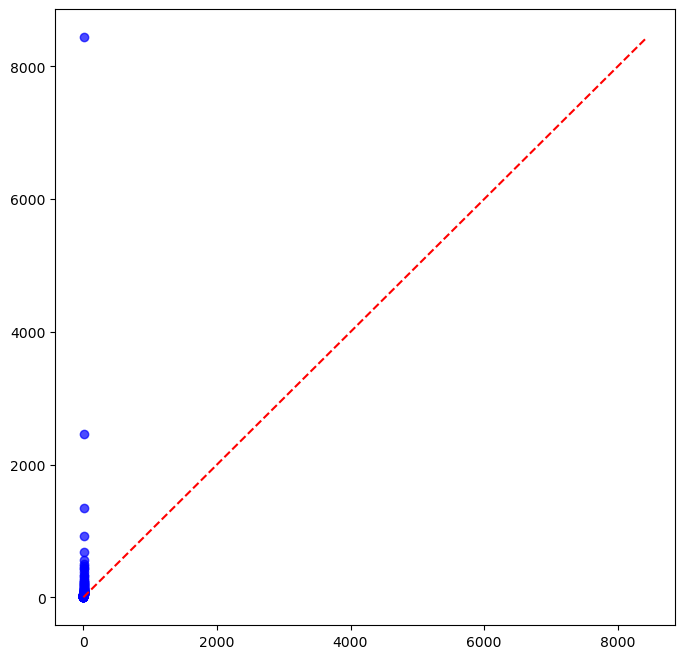

In [172]:
x_quantiles = np.quantile(testdata, np.linspace(0, 1, 100))
y_quantiles = np.quantile(samples_lognormal, np.linspace(0, 1, 100))

# Data plotten
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_quantiles, y_quantiles, alpha=0.7, color='blue')

# Rechte lijn plotten
min_val = min(testdata.min(), samples_lognormal.min())
max_val = max(testdata.max(), samples_lognormal.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--')

Ik denk nog steeds Poisson

### Methode 3. Anderson-Darling K-Sample Test
De Anderson-Darling K-Sample test is een wiskundige methode om te bepalen of meerdere datasets (*k* is het aantal datasets) dezelfde verdeling volgen. Het resultaat van de formule is een waarde die de *p-waarde* wordt genoemd waarmee je kunt bepalen of de datasets dezelfde verdeling volgen of niet. 

#### Theorie achter de test
Het idee achter de test is dat wanneer twee datasets dezelfde verdeling volgen, de cumulatieve frequentieverdelingen van beide datasets hetzelfde zijn. De Anderson-Darling test kwantificeert de verschillen tussen de cumulatieve frequentieverdelingen en kan daarmee een uitspraak doen. 

Hoe het proces precies verloopt is best complex, net zoals de formule:

$$A_{k}^2 = \frac{1}{N} \sum_{j=1}^{n-1} \frac{(NH_j - \sum_{i=1}^k n_i F_{ij})^2}{H_j(1-H_j)}$$

Hier zullen we niet verder op in gaan.

#### Interpretatie resultaat
Het belangrijkste is het resultaat van de formule: de p-waarde. Zo'n p-waarde wordt gebruikt bij het stellen van *hypotheses*. De  *nulhypothese* is in dit geval: *"De datasets volgen dezelfde verdeling."* Wanneer een p-waarde laag is (vaak < 0.05) wordt de nulhypothese *verworpen* hetgeen betekent dat de datasets **niet** dezelfde verdeling volgen. 

Dat wil niet zeggen dat bij een p-waarde groter dan 0.05 er 100% zeker sprake is van dezelfde verdeling. Een hogere p-waarde is een indicatie dat de verdelingen hetzelfde zijn, maar er is helaas geen harde grens wanneer je dat daadwerkelijk mag concluderen... Het enige dat je dus wel mag concluderen is dat twee datasets niet dezelfde verdeling volgen. Je zult dus op zoek moeten gaan naar een verdeling met een zo hoog mogelijke p-waarde.

#### Voordelen van de test
Het resultaat is, in tegenstelling tot het plotten van de datasets en de QQ-plot, kwantificeerbaar en dus objectiever maar helaas is er geen grens waarbij je 100% zeker bent. Er zijn ook andere tests die een kwantificeerbaar resultaat opleveren, maar die hebben nadelen zoals dat het al duidelijk moet zijn welke verdeling een dataset volgt of dat ze last hebben van grote datasets of outliers. De Anderson-Darling K-sample test heeft weinig nadelen, behalve dat deze niet zo goed werkt bij te kleine datasets of bij datasets met weinig diversiteit qua verschillende waardes.

In [173]:
# Functie om de Anderson-Darling K-Sample Test van scipy aan te roepen
def compare_distributions(data1, data2, alpha=0.05): 
    try:
        ad_result = anderson_ksamp([data1, data2], method=PermutationMethod())
        results = {
            'p-value': ad_result.pvalue,
            'same_distribution': ad_result.significance_level > alpha
        }
    except Exception as e:
        results = {
            'statistic': None,
            'same_distribution': False,
            'error': str(e)
        }
    return results

In [174]:
results = compare_distributions(uniforme_data, testdata)

for key, value in results.items():
    print(f"  {key}: {value}")

  p-value: 0.0001
  same_distribution: False


In bovenstaande code zie je dat de *significance level* berekend wordt. Wanneer deze score groter is dan 0.05 wordt de hypothese verworpen en hebben de datasets dezelfde verdeling. 

Het voordeel van deze test is dat deze objectief is: er is een kwantitatieve score in tegenstelling tot de eerste twee methodes.

### Opdracht 5
Bepaal voor elke van de vier gegeven datasets de significance level met de testdata. 

Bepaal op basis van de vorige opdrachten wat de verdeling is van de testdata.

In [175]:
#results = compare_distributions(testdata, samples_normaal)

#for key, value in results.items():
    #print(f"  {key}: {value}")

#results = compare_distributions(testdata, samples_lognormal)

#for key, value in results.items():
    #print(f"  {key}: {value}")

#results = compare_distributions(testdata, samples_uniform)

#for key, value in results.items():
    #print(f"  {key}: {value}")

#results = compare_distributions(testdata, samples_poisson)

#for key, value in results.items():
    #print(f"  {key}: {value}")

Het is een Poisson verdeling

## Synthetische data genereren
We hebben geleerd hoe je twee datasets kunt vergelijken. Bij de ICU casus hebben we historische data maar nog geen synthetische data: die moeten we eerst genereren. En daar lopen we tegen een *kip-ei probleem* aan:
- Om synthetische data te kunnen genereren, moeten we weten welke verdeling de historische data volgt
- Om te bepalen welke verdeling de historische data volgt, hebben we (synthetisch gegenereerde) testdata nodig

We ontkomen er niet aan om voor de historische data set meerdere testdatasets te genereren: voor elke relevante verdeling een. We moeten eerst bepalen welke verdelingen relevant zijn: een Poissonverdeling is wel relevant voor de aankomstdata maar niet voor de ligdata bijvoorbeeld.

Daarna kunnen we de historische data vergelijken met deze testdatasets en bepalen welke verdeling van toepassing is. We hanteren het volgende stappenplan:
1. Bepaal welke verdelingen relevant zijn;
2. Bepaal voor elke verdeling welke centrummaten, spreidingsmaten of andere parameters nodig zijn;
3. Bereken deze parameters voor de historische dataset;
4. Sample synthetische data op basis van deze parameters;
5. Vergelijk de historische dataset met de synthetische dataset.

Om data die een normaalverdeling volgt te kunnen genereren, moeten we dus het gemiddelde en de standaarddeviatie van de historische dataset berekenen. Daarna kunnen we een dataset genereren met een vergelijkbare grootte.

## Opdrachten ICU
We gaan synthetische data genereren op basis van de historische dataset. De dataset bevat twee features waarvoor synthetische data gegenereerd moet worden: de aankomstdata en de ligdata. 

### Deel 1 - Aankomstdata

**Opdracht 6.1.** Aantal aankomsten per tijdstip

Voor elk tijdstip van de ICU, moeten we bepalen hoeveel patiënten arriveerden op elk tijdstip. Neem de historische dataset en bereken voor elk tijdstip hoeveel patiënten arriveerden. 

**Opdracht 6.2.** Genereer synthetische data en bepaal verdeling

Genereer synthetische data volgens bovenstaand stappenplan en vergelijk deze data met de historische data. Kijk daarna welke van de relevante verdelingen het beste past. 

In [176]:
data = pd.read_csv("simulatiedata.csv")

aantal_per_tijdstip = data.groupby("Tijdstip")["Patient_ID"].count()

print(aantal_per_tijdstip)

Tijdstip
0      6
1      4
2      7
3      2
4      7
      ..
115    4
116    8
117    7
118    2
119    5
Name: Patient_ID, Length: 120, dtype: int64


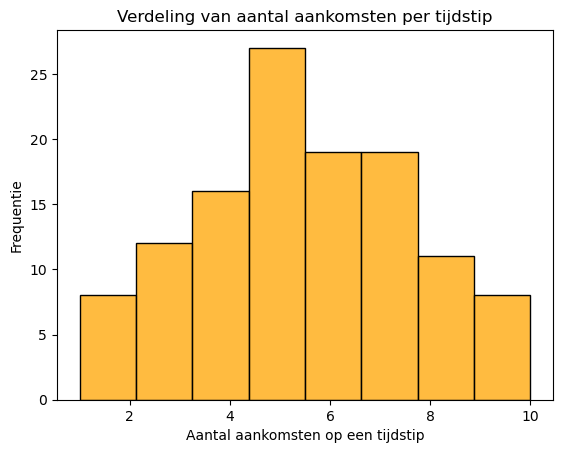

In [177]:
# 1. Bepaal welke verdelingen relevant zijn;
sns.histplot(aantal_per_tijdstip.values, color="orange")
plt.xlabel("Aantal aankomsten op een tijdstip")
plt.ylabel("Frequentie")
plt.title("Verdeling van aantal aankomsten per tijdstip")
plt.show()

Dit lijkt op een normaalverdeling of een poissonverdeling

In [178]:
# 2. Bepaal voor elke verdeling welke centrummaten, spreidingsmaten of andere parameters nodig zijn;

Voor de Poissonverdeling hebben we het gemiddelde nodig, voor de normaalverdeling het gemiddelde en de standaarddeviatie

In [179]:
# 3. Bereken deze parameters voor de historische dataset;
gem = aantal_per_tijdstip.mean()
std = aantal_per_tijdstip.std()

In [180]:
# 4. Sample synthetische data op basis van deze parameters;
poisson_sample = np.random.poisson(gem, 1000)
normaal_sample = np.random.normal(gem, std, 1000)

In [181]:
# 5. Vergelijk de historische dataset met de synthetische dataset.
results = compare_distributions(poisson_sample, aantal_per_tijdstip.values)

for key, value in results.items():
    print(f"  {key}: {value}")

results = compare_distributions(normaal_sample, aantal_per_tijdstip.values)

for key, value in results.items():
    print(f"  {key}: {value}")

  p-value: 0.2446
  same_distribution: True
  p-value: 0.2893
  same_distribution: True


Normaalverdeling past het beste

### Deel 2 - Ligdata

**Opdracht 7.** Genereer synthetische data

De ligtijd is wel vastgelegd in de dataset. Genereer synthetische data en vergelijk deze data met de historische data. Kijk daarna welke van de vier genoemde verdelingen het beste past. 

<Axes: xlabel='Ligtijd', ylabel='Count'>

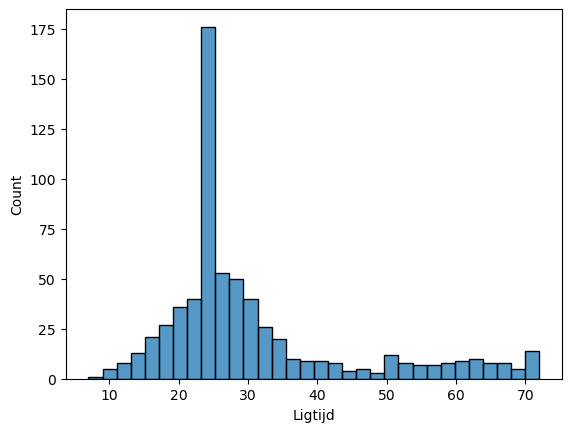

In [186]:
sns.histplot(data["Ligtijd"])

Relevant lijken mij: normaalverdeling, lognormaalverdeling, poissonverdeling

In [191]:
gem = np.mean(data["Ligtijd"])
std = np.std(data["Ligtijd"])

lognormal_sample = np.random.lognormal(gem, std, 1000)
normal_sample = np.random.normal(gem, std, 1000)
poisson_sample = np.random.poisson(gem, 1000)

results = compare_distributions(lognormal_sample, data["Ligtijd"])
for key, value in results.items():
    print(f"  {key}: {value}")

results = compare_distributions(normal_sample, data["Ligtijd"])
for key, value in results.items():
    print(f"  {key}: {value}")

results = compare_distributions(poisson_sample, data["Ligtijd"])
for key, value in results.items():
    print(f"  {key}: {value}")

  p-value: 0.0001
  same_distribution: False
  p-value: 0.0001
  same_distribution: False
  p-value: 0.0001
  same_distribution: False


### Deel 3 - Extra data manipulatie stap
***Spoiler alert***: het is niet mogelijk om passende verdelingen te vinden voor de gegeven dataset. Echter, door de data eerst te manipuleren kan het wel...! Deze opdracht maakt onderdeel uit van het portfolioitem 'Simulatie'.

**Opdracht 8.1.** Manipuleren

Denk na over manieren waarop je de data kunt manipuleren (bijv. opschonen, groeperen, filteren, verwijderen, ...) en voer deze uit. Voor daarna opdrachten 8.2 en 8.3 uit tot je een passende verdeling vindt. Voer daarna pas opdracht 8.4 uit.

**Opdracht 8.2.** Aantal aankomsten per tijdstip

Bereken opnieuw het aantal aankomsten per tijdstip. 

**Opdracht 8.3.** Genereer synthetische data aankomstdata 

Genereer synthetische data en vergelijk deze data met de historische data. Kijk daarna welke van de vier genoemde verdelingen het beste past. 

**Opdracht 8.4.** Genereer synthetische data ligdata

Genereer synthetische data en vergelijk deze data met de historische data. Kijk daarna welke van de vier genoemde verdelingen het beste past. 